In [ ]:
%pip install langgraph langchain langchain_openai langchain_community psycopg2 fpdf nest_asyncio
%pip install -q langfuse

In [373]:
import os, getpass, requests, psycopg2, datetime

from typing import TypedDict, List, Optional, Annotated
from IPython.display import Image, display
from operator import add

from langfuse import Langfuse
from langfuse.callback import CallbackHandler

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_openai import ChatOpenAI
from langchain.tools import tool
import nest_asyncio
from fpdf import FPDF

In [374]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("SERPAPI_API_KEY")
_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")
_set_env("LANGFUSE_HOST")
_set_env("GOOGLE_API_KEY")
_set_env("GOOGLE_CSE_ID")

langfuse = Langfuse(
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    host=os.environ["LANGFUSE_HOST"]
)

langfuse_handler = CallbackHandler()

In [375]:
class Draft(TypedDict):
    title: str
    body: str
    image: str

def update_draft(left: Draft | None, right: Draft | None) -> Draft:
    if left is None:
        return right
    if right is None:
        return left
    draft = Draft(
        title = right.get("title", left.get("title")),
        body = right.get("body", left.get("body")),
        image = right.get("image", left.get("image"))
    )
    return draft

class Source(TypedDict):
    title: str
    url: str
    content: str
    score: float

class State(MessagesState):
    prompt: str
    topic: str
    trending_topics: List[str]
    exclude: Annotated[List[str], add]
    fallback_to_trending: bool
    sources: Optional[List[Source]]
    draft: Annotated[Draft, update_draft]
    feedback_title: Optional[str]
    feedback_body: Optional[str]
    feedback_image: Optional[str]
    next: Optional[str]
    article: Optional[str]

In [376]:
db_name = os.getenv("POSTGRES_DB_NAME")
db_user = os.getenv("POSTGRES_USER")
db_psw = os.getenv("POSTGRES_PASSWORD")
db_host = os.getenv("POSTGRES_HOST")
db_port = os.getenv("POSTGRES_PORT")

conn = psycopg2.connect(
    dbname = db_name,
    user = db_user,
    password = db_psw,
    host = db_host,
    port = db_port
)

def save_article_to_db(article: str, topic: str):
    try:
        with conn.cursor() as cursor:
            cursor.execute(
                "INSERT INTO articles (topic, content) VALUES (%s, %s)",
                (topic.lower(), article)
            )
        conn.commit()
    except Exception as e:
        print(f"Error saving article to the database: {e}")
    finally:
        cursor.close()

def get_topics_from_db() -> List[str]:
    try:
        with conn.cursor() as cursor:
            cursor.execute("SELECT DISTINCT topic FROM articles")
            topics = [row[0] for row in cursor.fetchall()]
        return topics
    except Exception as e:
        print(f"Error fetching topics from the database: {e}")
        return []

In [377]:
@tool
def print_pdf(article: str) -> str:
    """
    Generate a PDF from the article content and save it to the specified directory.

    Returns:
        str: The path to the generated PDF file.
    """
    output_dir = "./generated_articles"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    if not article:
        raise ValueError("No article content provided.")

    title_line = article.split("\n", 1)[0].strip()
    title = title_line.split("#", 1)[1].strip() if "#" in title_line else title_line
    title_namefile = ''.join(e for e in title if e.isalnum() or e.isspace()).strip()

    image_url = ""
    if "![Image](" in article:
        start = article.index("![Image](") + len("![Image](")
        end = article.index(")", start)
        image_url = article[start:end]

    body_start = article.index(image_url + ")") + len(image_url + ")")
    body = article[body_start:].strip()

    filename = f"{datetime.date.today().strftime('%Y%m%d')}_{title_namefile[:50].replace(' ', '_')}.pdf"
    filepath = os.path.join(output_dir, filename)

    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    pdf.set_font("Arial", 'B', 16)
    pdf.multi_cell(0, 10, title)

    if image_url:
        image_path = "./temp_image.jpg"
        try:
            response = requests.get(image_url, stream=True)
            if response.status_code == 200:
                with open(image_path, "wb") as img_file:
                    img_file.write(response.content)
                pdf.image(image_path, w=150)
            else:
                print(f"Failed to download image. Status code: {response.status_code}")
        except Exception as e:
            print(f"Error downloading image: {e}")
        finally:
            if os.path.exists(image_path):
                os.remove(image_path)

    pdf.set_font("Arial", '', 12)
    pdf.ln(10)
    pdf.multi_cell(0, 10, body)

    pdf.output(filepath)
    return filepath

In [378]:
@tool
def print_markdown(article: str) -> str:
    """
    Generate a Markdown file from the article content and save it to the specified directory.

    Returns:
        str: The path to the generated Markdown file.
    """
    output_dir = "./generated_articles"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    if not article:
        raise ValueError("No article content provided.")

    filename = f"Article_{datetime.date.today().strftime('%Y%m%d')}.md"
    filepath = os.path.join(output_dir, filename)

    with open(filepath, "w", encoding="utf-8") as f:
        f.write(article)

    return filepath

In [ ]:
llm = ChatOpenAI(
    model="gpt-4.5-preview",
    temperature=0.7,
    streaming=True,
    verbose=True,
    callbacks=[langfuse_handler],
)

tools = [print_pdf, print_markdown]
llm_with_tools = llm.bind_tools(tools)

tavily = TavilySearchResults(max_results=5)

In [380]:
def get_user_prompt_node(state: State) -> State:
    '''
    Get the user prompt node.
    '''
    prompt = input(
        "Inserisci il prompt per l'articolo: "
    )

    return { "prompt": prompt }

In [381]:
def router_node(state: State) -> State:
    '''
    Decide whether to extract a topic or call the tool to get trending topics.
    If the user has clearly provided a topic, extract it.
    Otherwise, trigger the get_trending_topics tool.
    '''
    
    messages = [
        {
            "role": "system",
            "content": '''
                You are a helpful assistant that decides if a user has provided a clear article topic or needs suggestions.

                - If the user prompt clearly contains a topic, extract it as a short phrase.
                  For example, "How to train a dog" -> "dog training" or "The history of the internet" -> "internet history".
                
                - If the user is asking for suggestions or is too vague, respond with a function call to `get_trending_topics`.
                  For example, "What should I write about?" or "I need ideas for an article" should trigger the function call.
                
                Respond ONLY in one of the following formats:
                - To extract a topic: "topic: <topic>"
                - To call the function: "function: get_trending_topics"

                If the user gives a topic, extract in in english and remove any special characters or punctuation.
                '''
        },
        {
            "role": "user",
            "content": state["prompt"]
        }
    ]

    response = llm.invoke(messages)
    content = response.content

    if content.startswith("topic:"):
        topic = content.split("topic:")[1].strip()
        return { "topic": topic }
    elif content.startswith("function:"):
        return { "topic": None }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [382]:
def set_fallback_flag_node(state: State) -> State:
    '''
    Set the fallback flag to True if the source research does not return enough results.
    '''
    state["fallback_to_trending"] = True
    return state

In [383]:
def get_old_topics_node(state: State) -> State:
    '''
    Get the old topics from the database.
    '''
    
    return { "exclude": get_topics_from_db() }

In [384]:
def get_trending_topics_node(state: State) -> State:
    '''
    Get three the trending topics from Google Trends.
    Returns them and asks the user to choose one.
    Exclude the topics already proposed to the user.
    '''

    if state.get("fallback_to_trending", False):
        print("\nNon sono state trovate fonti sufficienti per il topic scelto.\nTi propongo tre nuovi argomenti di tendenza.\n", flush=True)

    exclude = state.get("exclude", None)

    url = "https://serpapi.com/search"
    params = {
        "engine": "google_trends_trending_now",
        "api_key": os.environ["SERPAPI_API_KEY"],
        "geo": "IT"
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise ValueError(f"Error fetching trending topics: {response.status_code}")
    data = response.json()

    trending_searches = []
    for trend in data.get("trending_searches", []):
        query = trend.get("query")
        if query:
            trending_searches.append(query)    

    if exclude is not None:
        trending_searches = [t for t in trending_searches if t not in exclude]

    return { "trending_topics": trending_searches[:3] }

In [385]:
def suggest_or_choose_topic_node(state: State) -> State:
    '''
    Suggest the trending topics to the user and ask him to choose one.
    Extract the topic from the user input if he chooses one, otherwise call the function again.
    '''

    trending_topics = state.get("trending_topics")

    suggestions = "\n".join([f"{i+1}. {t}" for i, t in enumerate(trending_topics)])
    print(f"\nEcco tre topic di tendenza:\n{suggestions}\n", flush=True)

    user_reply = input("Scrivi il topic che preferisci (anche non presente nella lista) o chiedi di vederne altri: ")

    messages = [
        {
            "role": "system",
            "content": '''
                You are a helpful assistant who suggests trending topics to the user and helps him choose one.

                You have suggested the following topics:
                {suggestions}

                Interpret the user reply:
                - If the user chooses one of the suggested topics, extract it.
                - If the user suggests a different topic, extract that.
                - If the user asks for more suggestions, respond exactly with "more_topics".

                Respond ONLY in one of the following formats:
                - To extract a topic: "topic: <topic>"
                - To get more topics: "more_topics"

                If the user gives a topic, extract it in english and remove any special characters or punctuation.
                '''
        },
        {
            "role": "user",
            "content": user_reply
        }
    ]

    response = llm.invoke(messages)
    content = response.content.strip()

    if content.startswith("topic:"):
        topic = content.split("topic:")[1].strip()
        return { "topic": topic }
    elif content == "more_topics":
        return { 
            "topic": None,
            "exclude": trending_topics,
            }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [386]:
def get_sources_node(state: State) -> State:
    '''
    Use Tavily to search for high-quality sources based on the topic.
    Filters results with score > 0.7 and keeps structured data.
    '''
    
    results = tavily.invoke({ "query": state["topic"] })

    formatted_results: List[Source] = [
        Source(
            title=r.get("title", ""),
            url=r.get("url", ""),
            content=r.get("content", ""),
            score=r.get("score", 0),
        )
        for r in results if r.get("score", 0) > 0.7
    ]

    return { "sources": formatted_results }

In [387]:
def draft_router(state: State) -> State:
    '''
    Route to the next state based on the current draft state.
    '''
    
    if state.get("draft", {}).get("title") is None or state.get("feedback_title") is not None:
        return { "next": "generate_title" }

    if state.get("draft", {}).get("body") is None or state.get("feedback_body") is not None:
        return { "next": "generate_body" }

    if not state.get("draft", {}).get("image") or state.get("feedback_image") is not None:
        return { "next": "generate_image" }

    return { "next": "render_article" }  

In [388]:
def generate_title_node(state: State) -> State:
    '''
    Generate a title for the article based on the topic and sources.
    '''

    prompt = f'''
    You are an expert article writer.
    Your task is to generate a catchy and clickbait title for the article based on the following topic and sources.

    Topic: {state["topic"]}
    Sources: {state["sources"]}
    '''

    if state.get("feedback_title") is not None:
        prompt += f'''\n
        You have received the following feedback on the title: 
        {state["feedback_title"]}.
        Use this feedback to improve the title.
        For example, if the feedback is "too long", make the title shorter.
        If the feedback is "not engaging", make the title more engaging.
        '''

    prompt += '''\n
    The title should be engaging and reflect the content of the article.
    Exagerate the topic and make it sound interesting.
    The title should be no more than 10 words long and should not contain any special characters or numbers.
    For example, if the topic is "dog training" and the sources are about dog training techniques, a possible title could be "The ultimate guide to dog training: tips and tricks".
    Only return the title.
    Do not include any additional text or explanations.
    The language of the title should be ITALIAN.
    '''

    response = llm.invoke(prompt)
    title = response.content.strip()
    return {
        "draft": {
            "title": title
        }
    }

In [389]:
def generate_body_node(state: State) -> State:
    '''
    Generate a draft for the article based on the topic and sources.
    '''
    
    urls = [source["url"] for source in state["sources"] if source["url"]]
    sources = "\n".join(urls)
    
    prompt = f'''
    You are a professional article writer.
    You have to write a detailed draft about the following topic: "{state["topic"]}".    

    Use **ONLY** the exact information contained in the following sources, and do not add anything that is not directly supported by them. 
    The draft should strictly reflect the facts as they are presented in the sources without any additional assumptions or unverified details:
    {sources}
    '''

    if state.get("feedback_body") is not None:
        prompt += f'''\n
        You have received the following feedback by the user: 
        "{state["feedback_body"]}".
        Use this feedback to improve the draft.
        '''

    prompt += f'''\n
    Make sure to mention the exact dates and details from the sources, without adding any speculative or external information. 
    The tone should be formal, informative, and objective.
    The article should be at least 500 words long and should not contain any grammatical or spelling errors.
    The language of the article should be ITALIAN.
    '''

    response = llm.invoke(prompt)
    body = response.content.strip()
    return {
        "draft": {
            "body": body
        }
    }

In [390]:
def generate_image_node(state: State) -> State:
    '''
    Generate a query for Google Custom Search Engine to find images related to the topic.
    Display the first image and update the draft with the image URL.
    '''

    prompt = f'''
    You are an image search agent.
    Your task is to generate a query to pass to the Google API to search for images related to the following topic: "{state["topic"]}".
    Return only the query, without any additional text.
    
    For example, if the topic is "World Cup final 2022", the query could be "world cup final 2022".
    '''

    if state.get("feedback_image") is not None:
        prompt += f'''\n
        You have received the following feedback by the user: 
        "{state["feedback_image"]}".
        Use this feedback to improve the query.
        For example, if the feedback is "I want images of Messi", make sure to include "Messi" in the query.
        If the topic is "World Cup final 2022" and the feedback is "I want images of Messi", the query could be "Messi world cup final 2022".
        If the topic is "Presidential elections USA 2024" and the feedback is "I want images of Trump", the query could be "Trump presidential elections USA 2024".
        '''

    response = llm.invoke(prompt)
    query = response.content.strip()

    api_key = os.getenv("GOOGLE_API_KEY")
    cx = os.getenv("GOOGLE_CSE_ID")
    if not api_key or not cx:
        raise RuntimeError("Setta GOOGLE_API_KEY e GOOGLE_CSE_ID nell'ambiente")
    
    endpoint = "https://www.googleapis.com/customsearch/v1"
    params = {
        "key": api_key,
        "cx": cx,
        "q": query,
        "searchType": "image",
        "num": 1,
        "imgSize": "medium",
        "imgColorType": "color",
    }

    resp = requests.get(endpoint, params=params)
    resp.raise_for_status()
    items = resp.json().get("items", [])

    url: str = items[0]["link"] if items else None

    return {
        "draft": {
            "image": url
        }
    }

In [391]:
def get_title_feedback_node(state: State) -> State:
    '''
    Ask the user for feedback on the generated title of the article.
    The system will interpret the feedback naturally.
    '''

    print(f"\nEcco il titolo dell'articolo:\n{state['draft']['title']}\n", flush=True)
    feedback = input("C'è qualcosa che vorresti migliorare o cambiare? ")

    prompt = f'''
    You are a helpful assistant who interprets user feedback on a title for an article.
    The user has provided the following feedback: "{feedback}".

    The title of the article is: "{state["draft"]["title"]}".
    
    Interpret the feedback and decide if the user is satisfied with the title or if he wants to change it.
    - If the user is satisfied, respond with "no_changes".
    - If the user wants to change the title, extract the changes he wants to make and respond with "changes: <changes>".
      For example, if the user says "I don't want the title to be title case", respond with "changes: remove title case".

    Do not include any additional text or explanations.
    '''

    response = llm.invoke(prompt)
    content = response.content.strip()

    if content == "no_changes":
        return { "feedback_title": None }
    elif content.startswith("changes:"):
        changes = content.split("changes:")[1].strip()
        return { "feedback_title": changes }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [392]:
def get_body_feedback_node(state: State) -> State:
    '''
    Ask the user for feedback on the generated body of the article.
    The system will interpret the feedback naturally.
    '''
    
    print(f"\nEcco il corpo dell'articolo:\n{state['draft']['body']}\n", flush=True)
    feedback = input("C'è qualcosa che vorresti migliorare o cambiare? ")

    prompt = f'''
    You are a helpful assistant that interprets user feedback on an article draft.
    The user has provided the following feedback: "{feedback}".

    Based on this feedback, decide if the user wants to change something in the article body.
    Use ONLY the following format to respond:
    - If the user wants to change something, extract the specific changes they want to make and respond with "changes: <changes>".
      For example, if the user says "Make it more detailed", respond with "changes: add more details".
      If the user says "Make it shorter", respond with "changes: shorten the article".
      If the user says "Add more examples", respond with "changes: add more examples".
    - If the user is satisfied with the draft, respond with "no_changes".
    
    Do not include any additional text or explanations.
    Respond ONLY in one of the following formats:
    - To extract changes: "changes: <changes>"
    - To indicate no changes: "no_changes"
    '''

    response = llm.invoke(prompt)
    content = response.content.strip()

    if content.startswith("changes:"):
        changes = content.split("changes:")[1].strip()
        return { "feedback_body": changes }
    elif content == "no_changes":
        return { "feedback_body": None }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [393]:
def get_image_feedback_node(state: State) -> State:
    '''
    Ask the user for feedback on the generated image of the article.
    The system will interpret the feedback naturally.
    '''

    print(f"\nEcco l'immagine dell'articolo:\n", flush=True)
    display(Image(url=state["draft"]["image"]))

    feedback = input("C'è qualcosa che vorresti migliorare o cambiare? ")

    prompt = f'''
    You are a helpful assistant that interprets user feedback on an article image.
    The user has provided the following feedback: "{feedback}".

    Based on this feedback, decide if the user wants to change something in the image.
    Use ONLY the following format to respond:
    - If the user wants to change something, extract the specific changes they want to make and respond with "changes: <changes>".
      For example, if the user says "The image must include a dog", respond with "changes: include a dog".
      If the user says "Add a logo", respond with "changes: add a logo".
    - If the user is satisfied with the image, respond with "no_changes".
    
    Do not include any additional text or explanations.
    Respond ONLY in one of the following formats:
    - To extract changes: "changes: <changes>"
    - To indicate no changes: "no_changes"
    '''

    response = llm.invoke(prompt)
    content = response.content.strip()

    if content.startswith("changes:"):
        changes = content.split("changes:")[1].strip()
        return { "feedback_image": changes }
    elif content == "no_changes":
        return { "feedback_image": None }
    else:
        raise ValueError(f"Unexpected response format: {content}")

In [394]:
def render_article_node(state: State) -> State:
    """
    Render the final article in Markdown format, including the title, body, and image.
    Saves the article into the database.
    """

    title = state.get("draft", {}).get("title", "")
    body = state.get("draft", {}).get("body", "")
    image = state.get("draft", {}).get("image", "")

    prompt = f'''
    You are a professional article writer.
    Your task is to render the final article in Markdown format, including the title, body, and image.

    The article should be well-structured and easy to read.
    The title should be in H1 format, the body should be in paragraphs.
    The image should be put below the title and above the body.

    If the body contains a title itself, remove it and keep only the content.

    Here are the details:
    Title: {title}
    Body: {body}
    Image: {image}

    The image is a url link to the image.
    So, it should be rendered as a Markdown image link, like this:
    ![Image](<image_url>)

    Do not include any additional text or explanations.
    Only return the final Markdown text.
    The language of the article should be ITALIAN.
    '''

    response = llm.invoke(prompt)
    article = response.content.strip()

    save_article_to_db(article, state["topic"])

    return { "article": article }

In [395]:
def handle_post_article_node(state: State) -> State:
    """
    Handle the post-article state.
    Ask the user if he wants to print the article.
    The only options are to print it as a PDF or Markdown file.
    """

    feedback = input("Vuoi stampare l'articolo? ")

    messages = [
        {
            "role": "system",
            "content": f'''
                You are a helpful assistant that interprets user feedback on an article post.

                The user has generated an article and is now deciding whether to print it or not.

                The article includes a title, body, and image.
                Article: {state["article"]}

                The user has the following options:
                - Print it as a PDF
                - Print it as a Markdown file
                - Do not print it AT ALL

                Based on the user feedback, decide if the user wants to print the article or not.
            '''
        },
        {
            "role": "user",
            "content": feedback
        }
    ]
    response = llm_with_tools.invoke(messages)
    print(response)
    if "__end__" in response:
        print("L'utente non vuole stampare l'articolo.")
    elif "print_pdf" in response:
        print("L'utente ha scelto di stampare l'articolo come PDF.")
    elif "print_markdown" in response:
        print("L'utente ha scelto di stampare l'articolo come Markdown.")
    return { "messages": response }

In [396]:
builder = StateGraph(State)

builder.add_node("get_user_prompt", get_user_prompt_node)
builder.add_node("router", router_node)
builder.add_node("get_old_topics", get_old_topics_node)
builder.add_node("get_trending_topics", get_trending_topics_node)
builder.add_node("set_fallback_flag", set_fallback_flag_node)
builder.add_node("suggest_or_choose_topic", suggest_or_choose_topic_node)
builder.add_node("get_sources", get_sources_node)
builder.add_node("draft_router", draft_router)
builder.add_node("generate_body", generate_body_node)
builder.add_node("generate_title", generate_title_node)
builder.add_node("generate_image", generate_image_node)
builder.add_node("title_feedback", get_title_feedback_node)
builder.add_node("body_feedback", get_body_feedback_node)
builder.add_node("image_feedback", get_image_feedback_node)
builder.add_node("render_article", render_article_node)
builder.add_node("handle_post_article", handle_post_article_node)
builder.add_node("tools", ToolNode([print_pdf, print_markdown]))

builder.add_edge(START, "get_user_prompt")
builder.add_edge("get_user_prompt", "router")
builder.add_conditional_edges(
    "router",
    lambda state: "topic" if state["topic"] else "no_topic",
    path_map = {
        "topic": "get_sources",
        "no_topic": "get_old_topics"
    }
)
builder.add_edge("get_old_topics", "get_trending_topics")
builder.add_edge("get_trending_topics", "suggest_or_choose_topic")
builder.add_conditional_edges(
    "suggest_or_choose_topic",
    lambda state: "chosen" if state["topic"] else "more",
    path_map = {
        "chosen": "get_sources",
        "more": "get_trending_topics"
    }
)
builder.add_conditional_edges(
    "get_sources",
    lambda state: "enough" if state["sources"] and len(state["sources"]) >= 2 else "not_enough",
    path_map = {
        "enough": "draft_router",
        "not_enough": "set_fallback_flag"
    }
)
builder.add_edge("set_fallback_flag", "get_trending_topics")
builder.add_conditional_edges(
    "draft_router",
    lambda output: output["next"],
    path_map={
        "generate_title": "generate_title",
        "generate_body": "generate_body",
        "generate_image": "generate_image",
        "render_article": "render_article",
    }
)
builder.add_edge("generate_title", "title_feedback")
builder.add_conditional_edges(
    "title_feedback",
    lambda state: "approved" if state.get("feedback_title") is None else "rejected",
    path_map={
        "approved": "draft_router",
        "rejected": "generate_title"
    }
)
builder.add_edge("generate_body", "body_feedback")
builder.add_conditional_edges(
    "body_feedback",
    lambda state: "approved" if state.get("feedback_body") is None else "rejected",
    path_map={
        "approved": "draft_router",
        "rejected": "generate_body"
    }
)
builder.add_edge("generate_image", "image_feedback")
builder.add_conditional_edges(
    "image_feedback",
    lambda state: "approved" if state.get("feedback_image") is None else "rejected",
    path_map={
        "approved": "draft_router",
        "rejected": "generate_image"
    }
)
builder.add_edge("render_article", "handle_post_article")
builder.add_conditional_edges(
    "handle_post_article",
    tools_condition,
)

memory = MemorySaver()

graph = builder.compile().with_config(
    callbacks=[langfuse_handler],
    memory=memory,
)

In [ ]:
graph.invoke({}, {"recursion_limit": 100})

In [400]:
conn.close()

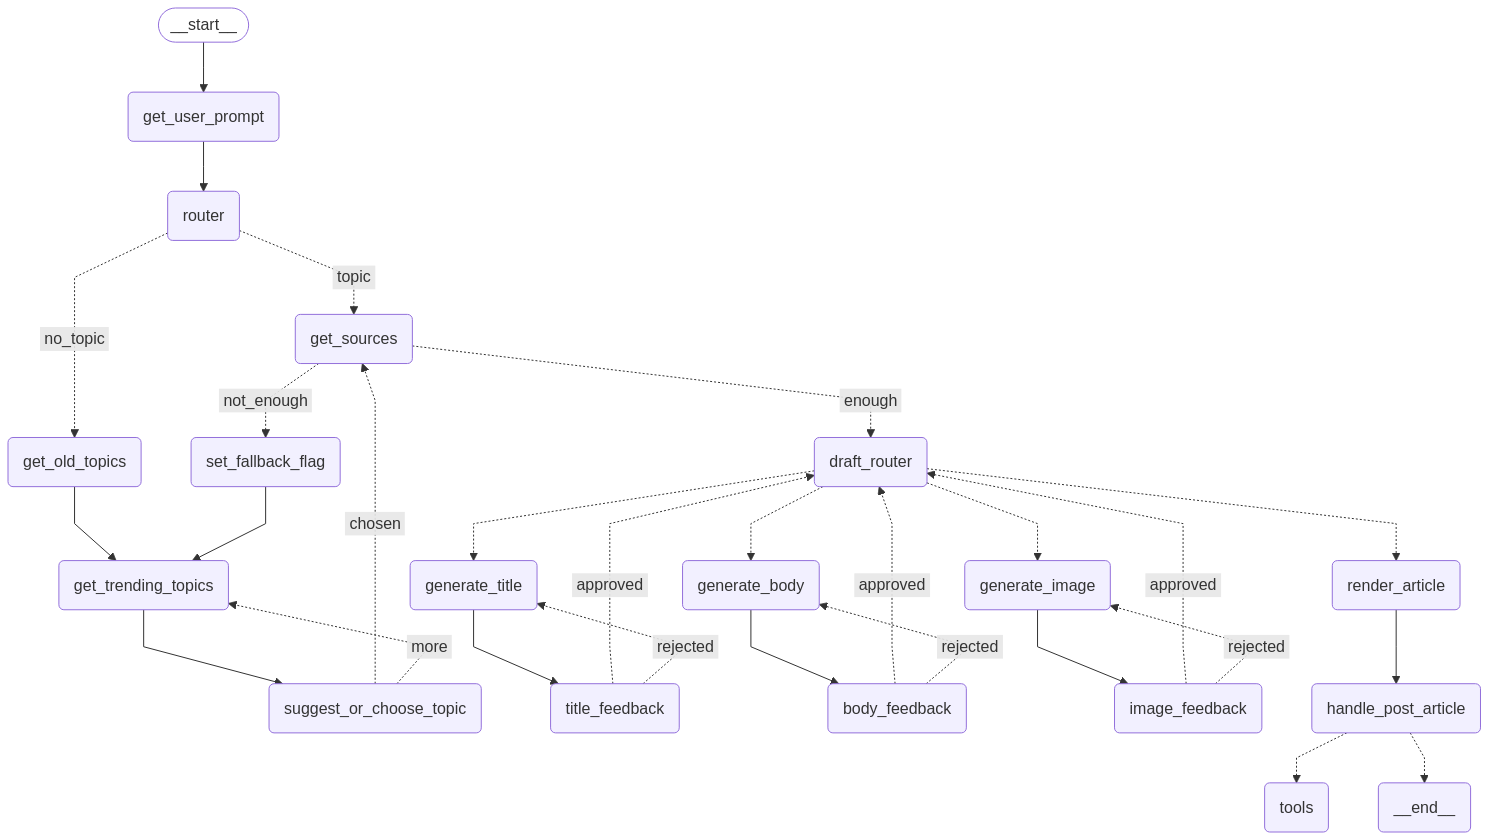

In [399]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    nest_asyncio.apply()
    display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))